# Introduction

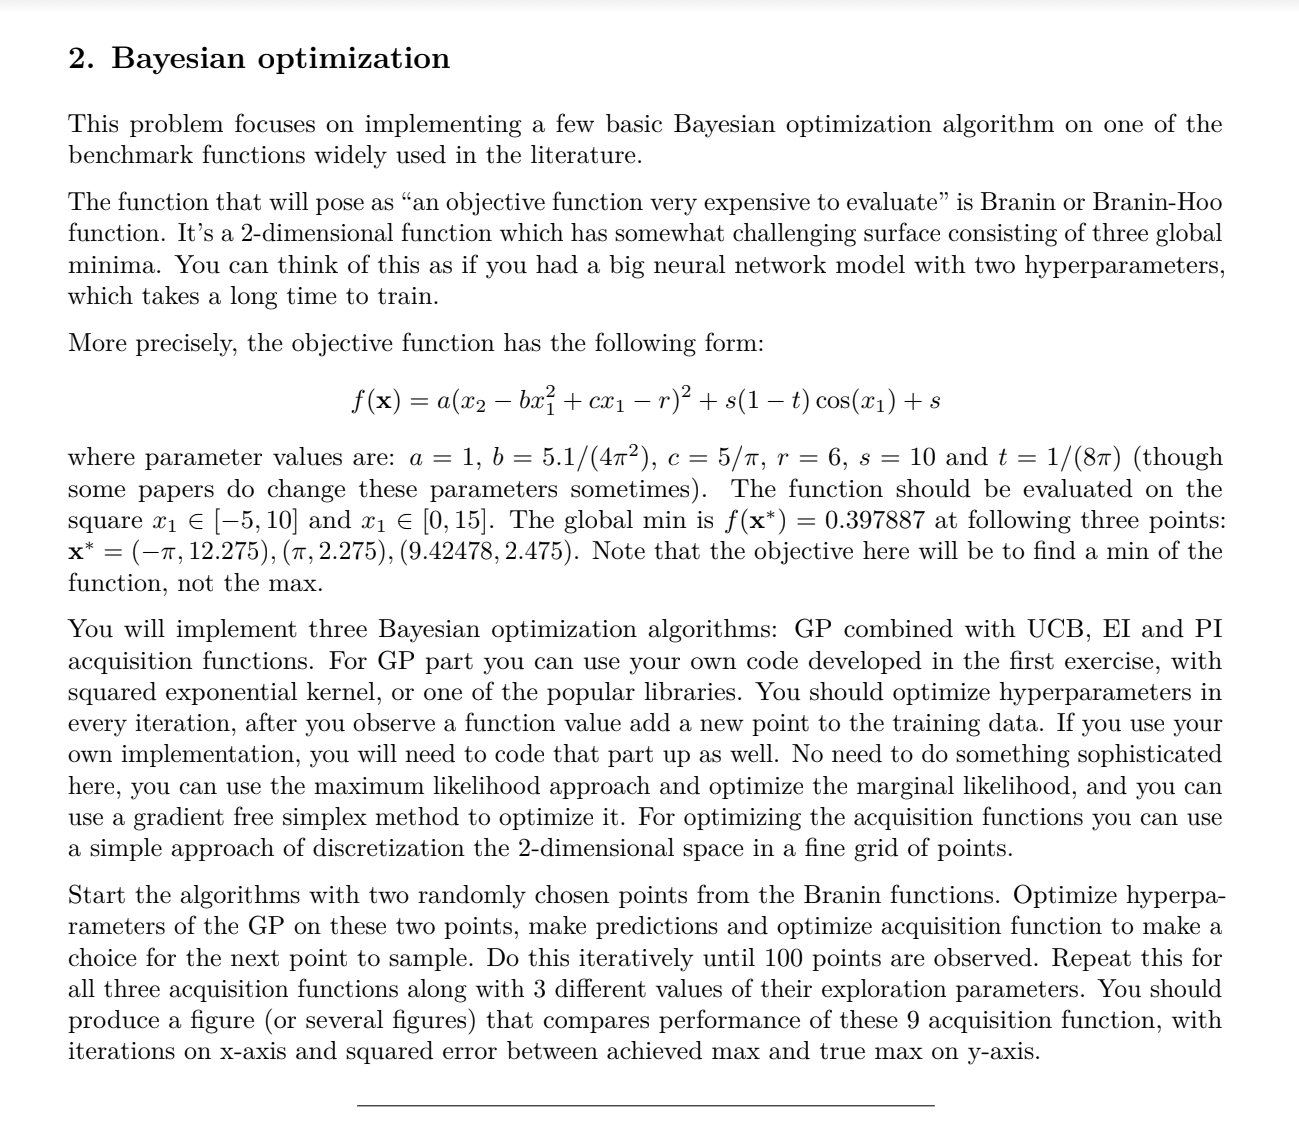

In [103]:
from IPython.display import Image
Image(filename='prob_ddf.png')

Sources : https://machinelearningmastery.com/what-is-bayesian-optimization/     

# Import packages

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
from mpl_toolkits.mplot3d import Axes3D
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from warnings import catch_warnings
from warnings import simplefilter
import warnings
from scipy.stats import norm
import seaborn as sns

# Define functions

In [3]:
def objective(x1, x2, noise = False, noise_var = 0.1, 
              a = 1, b = (5.1 / (4 * (np.pi**2))), c = (5/np.pi), r = 6, s = 10, t = 1/(8*np.pi)):   
    """ This function defines the quantity to be minimised; in this case, the Branin-Hoo function"""
        
    fx = a * ((x2- (b * (x1 **2))+ (c* x1) - r))**2 + (s * (1 - t) * np.cos(x1)) + s     
    if noise == True:
        fx += np.random.normal(0, noise_var)    
    return fx

def surrogate(model, X):
    """The surrogate function maps input values to output score with a lower computational burden.
    It is a surrogate or approximation for the objective function;
    It uses information pertaining to the conditional probability of the obj function given the available data"""
    # catch any warning generated when making a prediction
    with catch_warnings():
        # ignore generated warnings
        simplefilter("ignore")   
    return model.predict(X, return_std=True)

# Define search grid for acquisition function
grid = [[x1, x2] for x1 in np.arange(-5, 10, 0.1) for x2 in np.arange(0,15, 0.1)]

def acquisition(X,  model, acq_type, beta, eps, Xsamples = grid):
    """ Acquisition function, including PI, LCB and EI """
    # calculate the best surrogate score found so far
    yhat, _ = surrogate(model, X)
    best = min(yhat)
    # calculate mean and stdev via surrogate function
    mu, std = surrogate(model, Xsamples)
    # calculate the probability of improvement
    if acq_type == 'PI':
        probs = norm.cdf((best - mu) / (std+ 1E-9))
    elif acq_type == 'LCB':
        probs =  mu - (beta * std)
    elif acq_type == 'EI':
        probs = [expected_improvement(mu[i], std[i], best, eps) for i in range(0, len(mu))]
    return probs

def opt_acquisition(X, model, acq_type, beta, eps):
    """ Optimize the acquisition function"""
    # calculate the acquisition function for each sample
    scores = acquisition(X, model, acq_type, beta, eps)
    # locate the index of the best scores
    if acq_type == 'PI':
        idx = np.argmax(scores)
    elif acq_type == 'LCB' or acq_type == 'EI' :
        idx = np.argmin(scores)
    return grid[idx]

def expected_improvement(mean, std, bestsofar, eps):
    if std <= 0:
        ei = 0
    else: 
        Z = (mean - bestsofar - eps) / std
        ei = ((mean - bestsofar - eps) * norm.cdf(Z)) - (std * norm.pdf(Z))
    return ei   

# Explore Objective Function

Min1: -3.14 12.75 0.3979
Min2:  3.14 2.275 0.3979
Min3:  9.42 2.475 0.3979


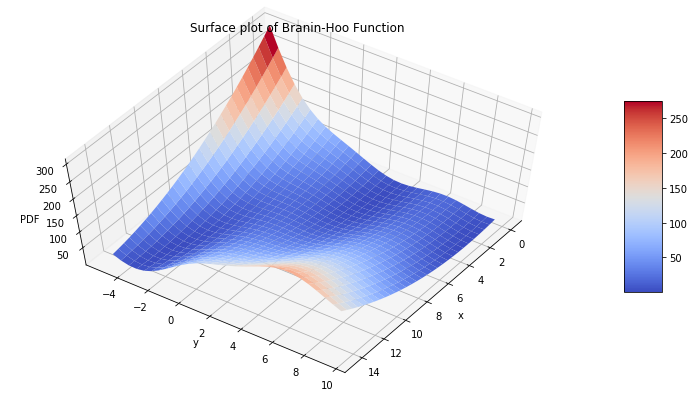

In [4]:
# Generate values for Branin-Hoo function over a grid 
xx = np.array([np.repeat(j, (15-0)/0.5) for j in np.arange(0,15,0.5)])
yy = np.array([np.arange(-5,10,0.5) for i in np.arange(0,15,0.5)])
f = np.array([[objective(y, x[0]) for y in yy[0]] for x in xx])

# Plot 
fig = plt.figure(figsize=(13, 7))
ax = plt.axes(projection='3d')
surf = ax.plot_surface(xx, yy, f, rstride=1, cstride=1, cmap='coolwarm', edgecolor='none')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('PDF')
ax.set_title('Surface plot of Branin-Hoo Function')
fig.colorbar(surf, shrink=0.5, aspect=5) # add color bar indicating the PDF
ax.view_init(60, 35)

# Print minima
print('Min1:' ,round(-np.pi,2),  12.75, round(objective( - np.pi, 12.275), 4))
print('Min2: ' , round(np.pi, 2), 2.275, round(objective( np.pi, 2.275), 4))
print('Min3: ', 9.42, 2.475, round(objective(9.42478, 2.475), 4))

# Bayesian Optimisation

In [ ]:
warnings.filterwarnings('ignore')

# Simulation parameters
num_iters = 10
repeats = 100

# Define the model
model = GaussianProcessRegressor(kernel =  1.0 * RBF(length_scale=1.0, length_scale_bounds=(1e-1, 10.0)))


# Initialise results dictionary
all_results = {}

for e in [0.01, 0.1, 0.2]:
    
    for b in [1,2,3]:

        for at in ['EI', 'LCB', 'PI']:

            results = np.zeros(num_iters+1)

            for j in range(0, repeats):

                # Initialise
                # # Choose 2 points randomly from the Branin functions
                X = [[round(np.random.uniform(-5, 10),1), round(np.random.uniform(0, 15),1)] for i in range(0,2)]
                fx = [objective(X[i][0], X[i][1], noise = False) for i in range(0,2) ]
                # Fit the model
                model.fit(X, fx)

                # Perform the optimization process
                for i in range(0, num_iters):
                    # 1. Select a Sample by Optimizing the Acquisition Function.
                    # select the next point to sample
                    s = opt_acquisition(X, model, acq_type = at, beta = b, eps = e)
                    # 2. Evaluate the Sample With the Objective Function.
                    # sample the point
                    actual = objective(s[0], s[1])
                    # 3. Update the Data and, in turn, the Surrogate Function.
                    # summarize the finding for our own reporting
                    est, _ = surrogate(model, np.array(s).reshape(1,-1))
                    print('>x1=%.3f,>x2=%.3f, f()=%3f, actual=%.3f' % (s[0], s[1], est[0], actual))
                    # add the data to the dataset
                    X = np.insert(X, 0, s, axis = 0)
                    fx = np.insert(fx, 0, actual)
                    # update the model (surrogate function)
                    model.fit(X, fx)      
                    # Best result
                    ix = np.argmin(fx)
                    # Record results
                    results[i] += (0.3979 - fx[ix]) ** 2

                # Print best result at the end of a run
                ix = np.argmin(fx)
                print('Best Result: x1=%.3f, x2=%.3f, fx=%.3f' % (X[ix][0], X[ix][1], fx[ix]))

            # Record result for given acquisition function
            all_results[str(at)+ '_b' + str(b) + '_e' + str(e)] = results / repeats

>x1=3.700,>x2=0.000, f()=36.444432, actual=5.390
>x1=-5.000,>x2=0.000, f()=-5.424742, actual=308.129
>x1=9.900,>x2=0.000, f()=-33.422340, actual=9.901
>x1=-5.000,>x2=14.900, f()=22.538319, actual=17.956
>x1=9.900,>x2=14.900, f()=37.375989, actual=145.341
>x1=5.900,>x2=3.600, f()=-7.347093, actual=25.122
>x1=7.600,>x2=0.900, f()=-1.130092, actual=12.630
>x1=7.100,>x2=0.000, f()=2.045891, actual=18.042
>x1=-0.100,>x2=14.900, f()=18.011057, actual=95.934
>x1=9.900,>x2=4.700, f()=-4.130973, actual=4.684
Best Result: x1=9.900, x2=4.700, fx=4.684
>x1=5.300,>x2=9.000, f()=4.037588, actual=76.263
>x1=-2.500,>x2=0.000, f()=8.545647, actual=118.651
>x1=3.800,>x2=14.900, f()=18.290512, actual=173.556
>x1=9.900,>x2=0.000, f()=17.314403, actual=9.901
>x1=-5.000,>x2=11.900, f()=-2.640124, actual=40.680
>x1=9.900,>x2=3.800, f()=17.342766, actual=2.263
>x1=-3.500,>x2=7.700, f()=13.544113, actual=30.743
>x1=9.900,>x2=2.700, f()=2.442535, actual=1.504
>x1=9.900,>x2=3.200, f()=1.496687, actual=1.549
>x1=

>x1=-1.700,>x2=7.400, f()=0.000000, actual=11.582
>x1=9.900,>x2=0.000, f()=0.000000, actual=9.901
>x1=2.500,>x2=14.900, f()=0.000000, actual=148.028
>x1=9.900,>x2=14.900, f()=0.000034, actual=145.341
>x1=7.200,>x2=4.300, f()=0.001063, actual=25.219
>x1=-5.000,>x2=10.800, f()=-6.364108, actual=53.522
>x1=2.700,>x2=8.100, f()=-14.065898, actual=31.081
>x1=5.800,>x2=0.000, f()=-0.167947, actual=19.746
Best Result: x1=3.300, x2=2.300, fx=0.539
>x1=3.100,>x2=9.200, f()=0.000000, actual=47.911
>x1=8.600,>x2=0.000, f()=0.000000, actual=6.969
>x1=9.500,>x2=14.900, f()=0.000000, actual=153.215
>x1=-5.000,>x2=7.200, f()=0.000000, actual=112.471
>x1=9.900,>x2=6.900, f()=0.000000, actual=17.422
>x1=2.500,>x2=14.900, f()=0.000004, actual=148.028
>x1=5.100,>x2=3.900, f()=0.000027, actual=20.688
>x1=-5.000,>x2=0.000, f()=0.000071, actual=308.129
>x1=4.400,>x2=0.000, f()=-19.617811, actual=9.294
>x1=-5.000,>x2=12.700, f()=-4.020938, actual=32.860
Best Result: x1=-3.300, x2=15.000, fx=5.999
>x1=-1.800,

>x1=-1.900,>x2=14.900, f()=0.000000, actual=36.161
>x1=0.700,>x2=2.000, f()=0.000010, actual=26.042
>x1=9.900,>x2=12.700, f()=0.001192, actual=97.403
>x1=-5.000,>x2=14.900, f()=-8.383044, actual=17.956
>x1=5.500,>x2=4.500, f()=3.688528, actual=27.998
>x1=2.600,>x2=0.000, f()=6.204351, actual=9.254
Best Result: x1=2.600, x2=0.000, fx=9.254
>x1=8.700,>x2=12.300, f()=5.492120, actual=110.317
>x1=9.900,>x2=0.000, f()=3.692593, actual=9.901
>x1=-5.000,>x2=8.200, f()=-7.730968, actual=93.496
>x1=0.600,>x2=0.000, f()=-5.418007, actual=43.849
>x1=6.100,>x2=3.700, f()=6.471177, actual=26.209
>x1=9.900,>x2=0.000, f()=9.901111, actual=9.901
>x1=9.900,>x2=0.000, f()=9.901111, actual=9.901
>x1=-5.000,>x2=8.200, f()=93.496394, actual=93.496
>x1=6.000,>x2=2.200, f()=24.948518, actual=20.427
>x1=2.500,>x2=4.400, f()=12.344738, actual=4.777
Best Result: x1=2.500, x2=4.400, fx=4.777
>x1=-4.800,>x2=12.800, f()=0.000000, actual=25.401
>x1=-5.000,>x2=0.000, f()=0.000000, actual=308.129
>x1=4.000,>x2=0.000,

>x1=0.500,>x2=6.200, f()=0.000003, actual=19.355
>x1=0.500,>x2=0.000, f()=0.000250, actual=45.848
>x1=4.900,>x2=0.000, f()=1.634657, actual=13.489
>x1=-5.000,>x2=14.900, f()=29.844380, actual=17.956
Best Result: x1=4.600, x2=2.300, fx=9.711
>x1=-3.600,>x2=1.700, f()=12.985017, actual=138.368
>x1=3.700,>x2=0.000, f()=6.686573, actual=5.390
>x1=9.900,>x2=8.400, f()=0.003155, actual=31.657
>x1=9.900,>x2=0.000, f()=0.292482, actual=9.901
>x1=2.200,>x2=6.600, f()=0.393863, actual=16.433
>x1=7.000,>x2=14.900, f()=0.397710, actual=205.225
>x1=-5.000,>x2=10.100, f()=-15.163443, actual=62.954
>x1=6.800,>x2=3.600, f()=2.457359, actual=24.346
>x1=6.500,>x2=0.000, f()=0.866864, actual=20.616
>x1=9.900,>x2=4.500, f()=4.978693, actual=4.006
Best Result: x1=9.900, x2=4.500, fx=4.006
>x1=-0.700,>x2=14.900, f()=2.116949, actual=76.983
>x1=-5.000,>x2=13.400, f()=-0.606043, actual=27.068
>x1=-5.000,>x2=0.000, f()=0.000000, actual=308.129
>x1=9.900,>x2=8.400, f()=2.545067, actual=31.657
>x1=9.900,>x2=14.9

>x1=7.600,>x2=0.000, f()=-0.770899, actual=14.278
>x1=9.700,>x2=2.800, f()=0.567924, actual=0.766
Best Result: x1=9.600, x2=2.700, fx=0.550
>x1=6.100,>x2=10.800, f()=9.400969, actual=113.560
>x1=-1.700,>x2=0.000, f()=31.326847, actual=91.191
>x1=-4.300,>x2=14.900, f()=25.069850, actual=6.262
>x1=-5.000,>x2=13.400, f()=4.764678, actual=27.068
>x1=9.900,>x2=0.000, f()=30.456142, actual=9.901
>x1=-1.600,>x2=14.900, f()=7.841887, actual=45.994
>x1=-5.000,>x2=14.600, f()=5.055391, actual=19.418
>x1=5.300,>x2=3.100, f()=3.588555, actual=18.958
>x1=9.900,>x2=4.800, f()=7.060976, actual=5.053
>x1=1.600,>x2=6.300, f()=11.565529, actual=16.049
Best Result: x1=9.900, x2=4.800, fx=5.053
>x1=-5.000,>x2=0.000, f()=0.000000, actual=308.129
>x1=8.500,>x2=6.800, f()=0.000000, actual=29.165
>x1=9.600,>x2=14.900, f()=0.000000, actual=151.177
>x1=-5.000,>x2=7.600, f()=0.000000, actual=104.641
>x1=-5.000,>x2=14.900, f()=0.000000, actual=17.956
>x1=9.900,>x2=0.000, f()=0.000000, actual=9.901
>x1=0.700,>x2=5

>x1=9.900,>x2=4.300, f()=1.688062, actual=3.408
Best Result: x1=9.900, x2=2.300, fx=1.828
>x1=-5.000,>x2=0.000, f()=0.000000, actual=308.129
>x1=-5.000,>x2=9.000, f()=0.000000, actual=79.757
>x1=-0.200,>x2=14.900, f()=0.000000, actual=92.967
>x1=1.300,>x2=7.200, f()=0.000000, actual=21.875
>x1=9.900,>x2=5.600, f()=0.000000, actual=8.725
>x1=9.900,>x2=0.000, f()=0.000006, actual=9.901
>x1=0.500,>x2=0.000, f()=0.000177, actual=45.848
>x1=4.400,>x2=0.000, f()=0.617629, actual=9.294
>x1=9.900,>x2=2.700, f()=1.267222, actual=1.504
>x1=9.900,>x2=3.800, f()=1.319957, actual=2.263
Best Result: x1=9.900, x2=2.700, fx=1.504
>x1=8.300,>x2=0.000, f()=0.000000, actual=8.713
>x1=8.800,>x2=9.200, f()=0.000000, actual=54.075
>x1=-5.000,>x2=0.000, f()=0.000000, actual=308.129
>x1=-5.000,>x2=9.500, f()=0.000000, actual=71.819
>x1=9.900,>x2=14.900, f()=0.000003, actual=145.341
>x1=2.900,>x2=0.000, f()=0.000030, actual=6.782
>x1=-4.200,>x2=14.900, f()=0.000042, actual=5.296
>x1=6.500,>x2=4.500, f()=0.0002

>x1=-5.000,>x2=5.700, f()=1.342241, actual=144.683
>x1=8.900,>x2=14.900, f()=-12.135332, actual=166.352
>x1=9.900,>x2=0.000, f()=-5.102143, actual=9.901
>x1=3.700,>x2=0.000, f()=6.026774, actual=5.390
>x1=-0.500,>x2=14.900, f()=-3.129785, actual=83.583
>x1=1.600,>x2=8.900, f()=4.384346, actual=35.891
>x1=9.900,>x2=4.600, f()=11.574871, actual=4.335
>x1=7.000,>x2=1.500, f()=-4.164899, actual=17.336
>x1=1.000,>x2=0.000, f()=8.804076, actual=35.778
Best Result: x1=9.900, x2=4.600, fx=4.335
>x1=-3.600,>x2=9.900, f()=13.397861, actual=13.666
>x1=-2.400,>x2=6.700, f()=-0.694698, actual=17.849
>x1=7.300,>x2=0.000, f()=0.000000, actual=16.654
>x1=-5.000,>x2=0.000, f()=0.000000, actual=308.129
>x1=9.900,>x2=14.900, f()=20.393332, actual=145.341
>x1=9.900,>x2=2.600, f()=18.724529, actual=1.555
>x1=9.900,>x2=0.000, f()=-8.798484, actual=9.901
>x1=-1.000,>x2=10.500, f()=-0.939530, actual=22.912
>x1=9.900,>x2=5.200, f()=9.275000, actual=6.729
>x1=-0.700,>x2=8.000, f()=-0.776576, actual=18.021
Best 

# Plot results 

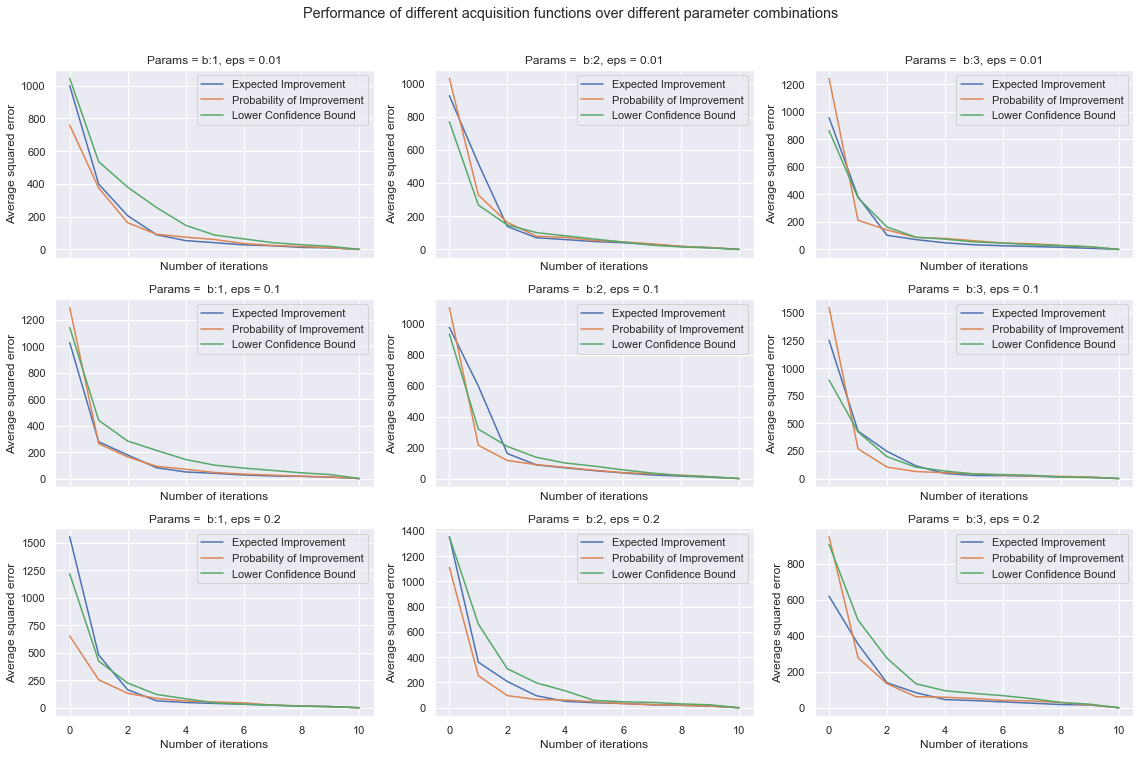

In [159]:
sns.set(rc={'figure.figsize':(16,10)})
fig, axs = plt.subplots(3,3,  sharex=True, sharey=False)
fig.suptitle('Performance of different acquisition functions over different parameter combinations', y = 1.05)

xxx = range(0, num_iters+1)

sns.lineplot(x= xxx, y = all_results['EI_b1_e0.01'], label = 'Expected Improvement', ax=axs[0,0]).set(title = 'Params = b:1, eps = 0.01', xlabel="Number of iterations", ylabel = "Average squared error")
sns.lineplot(x= xxx, y = all_results['LCB_b1_e0.01'], label = 'Probability of Improvement', ax = axs[0,0])
sns.lineplot(x= xxx, y = all_results['PI_b1_e0.01'], label = 'Lower Confidence Bound', ax = axs[0,0])

sns.lineplot(x= xxx, y = all_results['EI_b2_e0.01'], label = 'Expected Improvement', ax=axs[0,1]).set(title = 'Params =  b:2, eps = 0.01', xlabel="Number of iterations", ylabel = "Average squared error")
sns.lineplot(x= xxx, y = all_results['LCB_b2_e0.01'], label = 'Probability of Improvement', ax = axs[0,1])
sns.lineplot(x= xxx, y = all_results['PI_b2_e0.01'], label = 'Lower Confidence Bound', ax = axs[0,1])

sns.lineplot(x= xxx, y = all_results['EI_b3_e0.01'], label = 'Expected Improvement', ax=axs[0,2]).set(title = 'Params =  b:3, eps = 0.01', xlabel="Number of iterations", ylabel = "Average squared error")
sns.lineplot(x= xxx, y = all_results['LCB_b3_e0.01'], label = 'Probability of Improvement', ax = axs[0,2])
sns.lineplot(x= xxx, y = all_results['PI_b3_e0.01'], label = 'Lower Confidence Bound', ax = axs[0,2])

sns.lineplot(x= xxx, y = all_results['EI_b1_e0.1'], label = 'Expected Improvement', ax=axs[1,0]).set(title = 'Params =  b:1, eps = 0.1', xlabel="Number of iterations", ylabel = "Average squared error")
sns.lineplot(x= xxx, y = all_results['LCB_b1_e0.1'], label = 'Probability of Improvement', ax = axs[1,0])
sns.lineplot(x= xxx, y = all_results['PI_b1_e0.1'], label = 'Lower Confidence Bound', ax = axs[1,0])

sns.lineplot(x= xxx, y = all_results['EI_b2_e0.1'], label = 'Expected Improvement', ax=axs[1,1]).set(title = 'Params =  b:2, eps = 0.1', xlabel="Number of iterations", ylabel = "Average squared error")
sns.lineplot(x= xxx, y = all_results['LCB_b2_e0.1'], label = 'Probability of Improvement', ax = axs[1,1])
sns.lineplot(x= xxx, y = all_results['PI_b2_e0.1'], label = 'Lower Confidence Bound', ax = axs[1,1])

sns.lineplot(x= xxx, y = all_results['EI_b3_e0.1'], label = 'Expected Improvement', ax=axs[1,2]).set(title = 'Params =  b:3, eps = 0.1', xlabel="Number of iterations", ylabel = "Average squared error")
sns.lineplot(x= xxx, y = all_results['LCB_b3_e0.1'], label = 'Probability of Improvement', ax = axs[1,2])
sns.lineplot(x= xxx, y = all_results['PI_b3_e0.1'], label = 'Lower Confidence Bound', ax = axs[1,2])

sns.lineplot(x= xxx, y = all_results['EI_b1_e0.2'], label = 'Expected Improvement', ax=axs[2,0]).set(title = 'Params =  b:1, eps = 0.2', xlabel="Number of iterations", ylabel = "Average squared error")
sns.lineplot(x= xxx, y = all_results['LCB_b1_e0.2'], label = 'Probability of Improvement', ax = axs[2,0])
sns.lineplot(x= xxx, y = all_results['PI_b1_e0.2'], label = 'Lower Confidence Bound', ax = axs[2,0])

sns.lineplot(x= xxx, y = all_results['EI_b2_e0.2'], label = 'Expected Improvement', ax=axs[2,1]).set(title = 'Params =  b:2, eps = 0.2', xlabel="Number of iterations", ylabel = "Average squared error")
sns.lineplot(x= xxx, y = all_results['LCB_b2_e0.2'], label = 'Probability of Improvement', ax = axs[2,1])
sns.lineplot(x= xxx, y = all_results['PI_b2_e0.2'], label = 'Lower Confidence Bound', ax = axs[2,1])

sns.lineplot(x= xxx, y = all_results['EI_b3_e0.2'], label = 'Expected Improvement', ax=axs[2,2]).set(title = 'Params =  b:3, eps = 0.2', xlabel="Number of iterations", ylabel = "Average squared error")
sns.lineplot(x= xxx, y = all_results['LCB_b3_e0.2'], label = 'Probability of Improvement', ax = axs[2,2])
sns.lineplot(x= xxx, y = all_results['PI_b3_e0.2'], label = 'Lower Confidence Bound', ax = axs[2,2])

plt.legend()
plt.tight_layout(pad=1.08)

Ideas for further development:
- Reduce grid size as you approach the minimum
- Try random restarts
- Add  noise to objective function